In [1]:
!pip install tensorflow opencv-python matplotlib

In [1]:
import cv2
import os
import random
import uuid
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [55]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [56]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

RuntimeError: Physical devices cannot be modified after being initialized

In [57]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [14]:
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [15]:
# !tar -xf lfw-funneled.tgz

In [19]:
for directory in os.listdir('lfw_funneled'):
    for file in os.listdir(os.path.join('lfw_funneled', directory)):
        EX_PATH = os.path.join('lfw_funneled', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [32]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    
    frame = frame[60:60+250, 230:230+250, :]
    
    if cv2.waitKey(1) == ord('a'):
        imgname = os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(imgname, frame)
        
    if cv2.waitKey(1) == ord('p'):
        imgname = os.path.join(POS_PATH, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

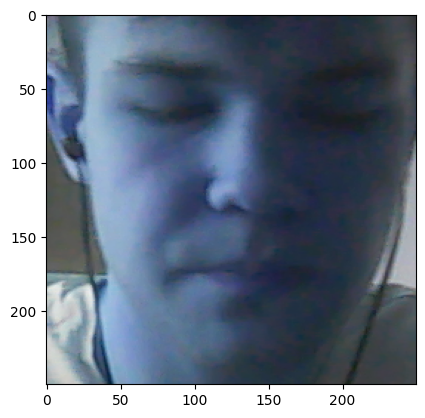

In [26]:
plt.imshow(frame[60:60+250, 230:230+250, :])

'6284bbb5-ddfa-11ee-85e3-185e0f1d68b5.jpg'

In [58]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [25]:
anchor.as_numpy_iterator().next()

b'data\\anchor\\36f1c99f-ddfb-11ee-90ff-185e0f1d68b5.jpg'

In [3]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(105, 105))
    img = img / 255.
    return img

In [158]:
img = preprocess('data\\anchor\\21c2b605-ddfb-11ee-ba8f-185e0f1d68b5.jpg')

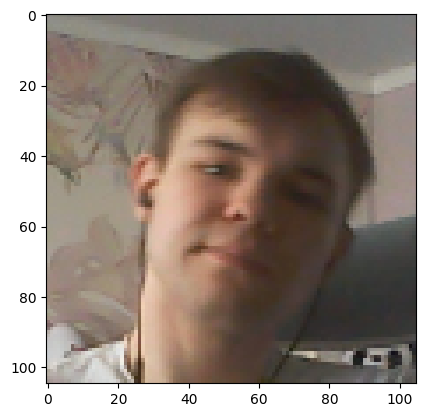

In [159]:
plt.imshow(img)

In [160]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives) 

In [161]:
example = data.as_numpy_iterator().next()

In [162]:
def preprocess_pair(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [163]:
res = preprocess_pair(*example)

In [178]:
type(res[0])

tensorflow.python.framework.ops.EagerTensor

In [67]:
data = data.map(preprocess_pair)
data = data.cache()
data = data.shuffle(buffer_size=1000)

In [68]:
samples = data.as_numpy_iterator()

In [69]:
test = samples.next()

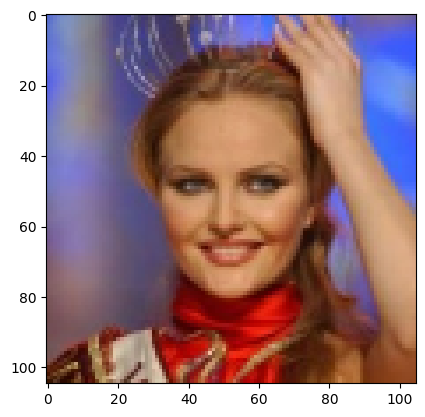

In [70]:
plt.imshow(test[1])

In [71]:
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [72]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [73]:
def make_embedding():
    inp = Input(shape=(105, 105, 3), name='imput_image')
    
    conv1 = Conv2D(64, (10,10), activation='relu')(inp)
    max_pool1 = MaxPooling2D(64, (2,2), padding='same')(conv1)
    
    conv2 = Conv2D(128, (7,7), activation='relu')(max_pool1)
    max_pool2 = MaxPooling2D(64, (2,2), padding='same')(conv2)
    
    conv3 = Conv2D(128, (4,4), activation='relu')(max_pool2)
    max_pool3 = MaxPooling2D(64, (2,2), padding='same')(conv3)
    
    conv4 = Conv2D(256, (4, 4), activation='relu')(max_pool3)
    flat = Flatten()(conv4)
    dense = Dense(4096, activation='sigmoid')(flat)
    
    
    
    return Model(inputs=[inp], outputs=[dense], name='embedding')

In [74]:
model = make_embedding()

In [75]:
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 imput_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [4]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [77]:
l1 = L1Dist()

In [78]:
def make_siamese_model():
    
    input_image = Input(name='input_image', shape=(105, 105, 3))
    validation_image = Input(name='validation_image', shape=(105, 105, 3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distance = siamese_layer(model(input_image), model(validation_image))
    
    classifier = Dense(1, activation='sigmoid')(distance)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [79]:
siamese_model = make_siamese_model()

In [80]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

In [81]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [82]:
opt = tf.keras.optimizers.Adam(0.0001)

In [83]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [84]:
test_batch = train_data.as_numpy_iterator()

In [85]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        
        loss = binary_cross_loss(y, yhat)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [86]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print(f'\n Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
            
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [87]:
EPOCHS = 60

In [88]:
train(train_data, EPOCHS)


 Epoch 1/60
27/27 [==============================] - 58s 2s/step

 Epoch 2/60
27/27 [==============================] - 63s 2s/step

 Epoch 3/60
27/27 [==============================] - 89s 3s/step

 Epoch 4/60
27/27 [==============================] - 110s 4s/step

 Epoch 5/60
27/27 [==============================] - 110s 4s/step

 Epoch 6/60
27/27 [==============================] - 110s 4s/step

 Epoch 7/60
27/27 [==============================] - 99s 4s/step

 Epoch 8/60
27/27 [==============================] - 80s 3s/step

 Epoch 9/60
27/27 [==============================] - 80s 3s/step

 Epoch 10/60
27/27 [==============================] - 80s 3s/step

 Epoch 11/60
27/27 [==============================] - 63s 2s/step

 Epoch 12/60
27/27 [==============================] - 71s 3s/step

 Epoch 13/60
27/27 [==============================] - 72s 3s/step

 Epoch 14/60
27/27 [==============================] - 92s 4s/step

 Epoch 15/60
27/27 [==============================] - 110s 4s/step


In [27]:
from tensorflow.keras.metrics import Precision, Recall

In [89]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [90]:
test_input.shape

(16, 105, 105, 3)

In [147]:
test_val.shape

(16, 105, 105, 3)

In [92]:
len(test_data)

12

In [110]:
[test_input, test_val]

2

In [94]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 192ms/step


array([[1.0000000e+00],
       [4.3174537e-06],
       [3.2080415e-08],
       [9.9999821e-01],
       [2.6064316e-05],
       [4.1763091e-08],
       [6.2107532e-08],
       [5.6243742e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0171482e-06],
       [2.8802298e-09],
       [9.9999344e-01],
       [9.2670831e-08],
       [1.4662785e-05],
       [1.0000000e+00]], dtype=float32)

In [121]:
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

In [122]:
y_hat

[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]

In [123]:
y_true

array([1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.],
      dtype=float32)

In [105]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [183]:
tmp = test_data.as_numpy_iterator()

In [184]:
test_input, test_val, y_true = tmp.next()

In [206]:
test_input.shape

(16, 105, 105, 3)

In [28]:
for i in range(len(test_data)):
    test_input, test_val, y_true = tmp.next()
    y_hat = model.predict([test_input, test_val])
    print(y_hat)
    m = Precision()
    m.update_state(y_true, y_hat)
    print(m.result().numpy())

1/1 [==============================] - 0s 23ms/step
[[2.4238099e-05]
 [9.8759693e-01]
 [1.0000000e+00]
 [3.0396251e-08]
 [6.5506242e-06]
 [1.0000000e+00]
 [4.8245468e-08]
 [1.0000000e+00]
 [4.6011394e-08]
 [9.9637134e-08]
 [5.7877690e-01]
 [1.0000000e+00]
 [3.4755143e-08]
 [1.7721528e-07]
 [1.5285846e-07]
 [1.0000000e+00]]
1.0
1/1 [==============================] - 0s 50ms/step
[[1.0000000e+00]
 [5.9924503e-08]
 [1.8913538e-07]
 [4.6291145e-08]
 [9.9998033e-01]
 [7.1295247e-08]
 [1.7716527e-03]
 [9.9997020e-01]
 [1.1866505e-08]
 [1.0000000e+00]
 [3.0643500e-06]
 [9.4891286e-01]
 [1.6394440e-06]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9899858e-01]]
1.0
1/1 [==============================] - 0s 48ms/step
[[8.5933543e-08]
 [1.3066601e-07]
 [1.0000000e+00]
 [3.7801119e-08]
 [1.3283595e-04]
 [2.2424418e-04]
 [7.6993275e-01]
 [3.0663017e-05]
 [1.7229071e-07]
 [8.3507416e-08]
 [1.4856950e-07]
 [1.1181131e-05]
 [2.2561390e-07]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]]
1.0
1/1 [========

StopIteration: 

In [32]:
tmp = test_data.as_numpy_iterator() 

In [42]:
test_input, test_val, true_val = tmp.next()

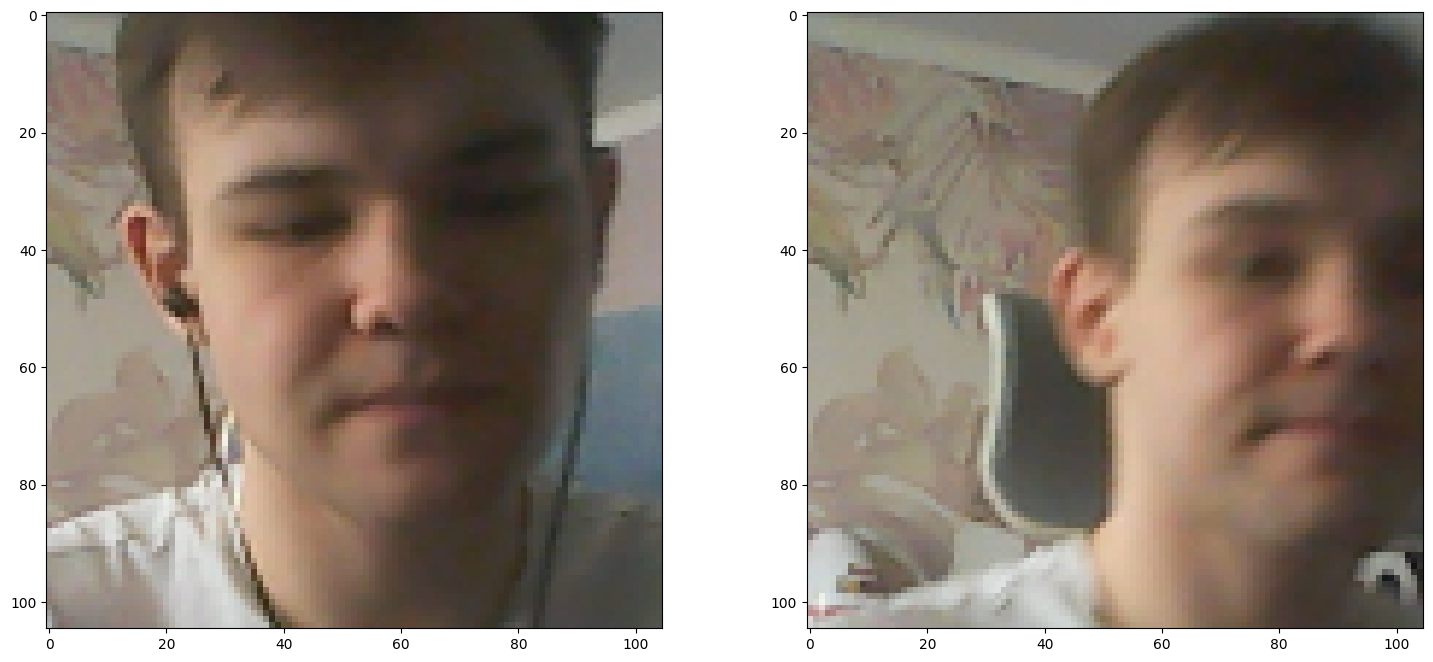

In [44]:
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])
plt.subplot(1, 2, 2)
plt.imshow(test_val[0])
plt.show()

In [45]:
print(true_val[0])

1.0


In [151]:
siamese_model.save('siamese_model_v2.h5')

In [7]:
model = load_model('siamese_model_v2.h5',
                                 custom_objects={'L1Dist':L1Dist, 'BinatyCrossentropy':tf.losses.BinaryCrossentropy})

In [6]:
from tensorflow.keras.models import load_model

In [16]:
insert_photo = preprocess('data\\anchor\\21c2b605-ddfb-11ee-ba8f-185e0f1d68b5.jpg')

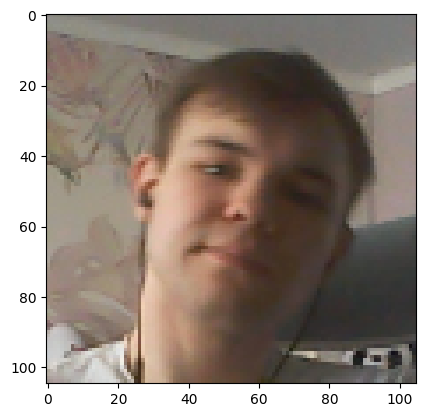

In [17]:
plt.imshow(insert_photo)

In [18]:
val_photo = preprocess(os.path.join('test.jpg'))

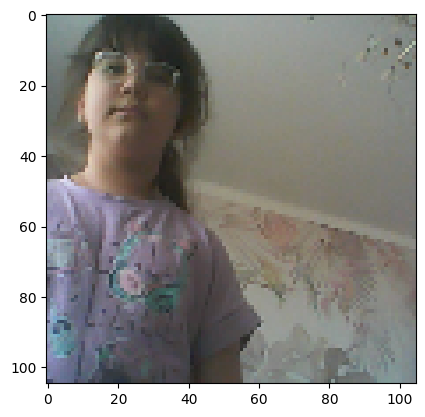

In [19]:
plt.imshow(val_photo)

In [20]:
res = model.predict(list(np.expand_dims([insert_photo, val_photo], axis=1)))

1/1 [==============================] - 0s 28ms/step


In [21]:
res[0][0]

0.99465746

In [7]:
test_path = os.path.join('data', 'test')

In [8]:
os.path.exists(test_path)

True

In [19]:
test = tf.data.Dataset.list_files(test_path+'\*.jpg').take(16)

In [18]:
test.as_numpy_iterator().next()

b'data\\test\\e1cd458e-ddfb-11ee-9588-185e0f1d68b5.jpg'

In [20]:
data = test.map(preprocess)

In [21]:
data.as_numpy_iterator().next().shape

(105, 105, 3)

In [75]:
tmp = np_data.next()

In [76]:
tmp = tf.expand_dims(tmp, 0)

In [77]:
tmp.shape

TensorShape([1, 105, 105, 3])

In [42]:
np_data = data.as_numpy_iterator()
res = []
for i in range(len(data)):
    photo_to_compare = np_data.next()
    photo_to_compare = tf.expand_dims(photo_to_compare, 0)
    res.append(model.predict([photo_to_compare, other_photo])[0][0])
print(res)

1/1 [==============================] - 0s 28ms/step
[0.7599929, 1.0, 0.99999976, 0.9999995, 1.0, 1.0, 0.99923325, 1.0, 1.0, 0.09043787, 1.0, 0.9999616, 0.99904925, 1.0, 0.9999243, 0.9298212]


In [43]:
np.array(res).mean()

0.9236512